# Part 3 : Analyze MMLU 24 choices dataset  

We have 24 shuffles per question.  
In this dataset, we have the 24 corresponding inferred answers from LLM LLAMA3-8B BNB.  
(result from Part 2 : complete inference)  

We now need to make a vote (get the majority answer) for all questions.  
Then, we will analyze the results:  
- how many votes are necessary to improve performance without spending too much on computation?  
- are the votes that decrease the global mean accuracy metric?  
- are there letter orders that benefit from being outliers in the voting strategy?  

We will also see which letter combination got the best score at this benchmark, and analyze the influence of a given letter position in a letter order.  

This notebook contains lots of boring accuracy tables, please scroll fast to see the interesting Seaborn plots towards the end.  

In [1]:
!pip install python-Levenshtein

## load dataset

In [2]:
from datasets import load_dataset, get_dataset_config_names
from tqdm.auto import tqdm

dataset_ds = load_dataset("the-french-artist/shuffled_mmlu_no_splits_unsloth_llama-3-8b-bnb-4bit_fixed", 
                          split='train', 
                          download_mode='force_redownload'
                         )
dataset_ds

Generating train split:   0%|          | 0/337008 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'choices', 'answer', 'question_id', 'category', 'letter_order', 'inferred_answer'],
    num_rows: 337008
})

In [3]:
dataset_df = dataset_ds.to_pandas()
# del dataset_df['__index_level_0__']
dataset_df.head()

,question,choices,answer,question_id,category,letter_order,inferred_answer
0,Find the degree for the given field extension ...,"[0, 4, 2, 6]",1,bc3778ec85a3abdf375449e14780a1318d32e859c2a2c1...,abstract_algebra,ABCD,2
1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...","[8, 2, 24, 120]",2,9dbee06135bb2cd4f1d6fc47c5b9698485a7758ce3ee76...,abstract_algebra,ABCD,1
2,Find all zeros in the indicated finite field o...,"[0, 1, 0,1, 0,4]",3,4cfb894cedaec3e7dee2ba71a6a781fbf1d0ded44bac22...,abstract_algebra,ABCD,2
3,Statement 1 | A factor group of a non-Abelian ...,"[True, True, False, False, True, False, False,...",1,7bdc038b56be4a1a507b6d156e061fc66c43098d756822...,abstract_algebra,ABCD,0
4,Find the product of the given polynomials in t...,"[2x^2 + 5, 6x^2 + 4x + 6, 0, x^2 + 1]",1,ff99adc312cd773b4959d6f9398f00342297a0d0379c65...,abstract_algebra,ABCD,1


## Check some stats about the dataset  
Before delving into the result analysis, we must make sure the dataset is OK.  

### check uniqueness of question_id  

We have 24 shuffles per question.  
the assertion below should be true:

In [4]:
len(dataset_df)/24 == len(dataset_df.question_id.unique())

True

We expect to see 24 rows per unique question_id:

In [5]:
dataset_df.question_id.value_counts()

question_id
bc3778ec85a3abdf375449e14780a1318d32e859c2a2c16ca422eaf4349ae6bc    24
e1b9ce3aa1729e38a0ad50d9d61066187eadddb9ff7967cc0c94b97643201334    24
a7dd0fadbe7889b8a339a0a7221ec94ce15476eef1292d263ee6593940a93f16    24
59f25f85093da913ec051c4a9b57552da83bcd9afb01ddf225ed1def13c08cbd    24
7f2a08c5d15370f23d535cf6e02c6801f23a6404447c3cdc227bd74aa44e48b1    24
                                                                    ..
ce44c809afcb08fdd18d87c4067dbfbeb3edf5e20dac5a113a2837d5eaacd01c    24
7102862c0f284391e57e622ac4ca2273e58f7de296d0964cf0c6c86eeee53b17    24
db9c1a12cdbeae4ce5711642afeb045d94d46dff0bdd6177bcb9a0e17b37ce99    24
2fbe12e9363217e0c5350a4b69a531563d740b12d83e0ef3983e9c3aa334b17b    24
bd9f02cc864917b5a2b6ecad1f149247a362bd459eb62967febe1c9e5d3b19a1    24
Name: count, Length: 14042, dtype: int64

### Compare answer counts between expected answer and inferred answer  

The expected answer `answer` is the actual expected answer to the question.  
`inferred_answer` is the answer provided by the LLM.  

We should see a balanced value count across all 4 classes.  

Expected answers: perfectly balanced.  

In [6]:
dataset_df.answer.value_counts().to_frame().reset_index().sort_values('answer')

,answer,count
3,0,84252
0,1,84252
1,2,84252
2,3,84252


Inferred answers: we see a BIG imbalance, with a preference for middle answers (B and C).  

In [7]:
dataset_df.inferred_answer.value_counts().to_frame().reset_index().sort_values('inferred_answer')

,inferred_answer,count
2,0,49793
0,1,131246
1,2,125204
3,3,30765


## Perform vote for each question  
We get the majority answer for each question.  
`inferred_answer` is as follows:  
0 = A  
1 = B  
2 = C  
3 = D  
(no matter the letter order)  

We have to translate the answer so it is compatible with the original question.  
Eg. 
ABCD question has choice A as correct answer.  
DCBA question has choice D as correct answer.  
This is equivalent because answer A has been moved to the D position.  


### Get popular answer for all questions

In [8]:
letter_to_number = {
    "A" : 0,
    "B" : 1,
    "C" : 2,
    "D" : 3,
}

def translate_local_answer_to_global_answer(row):
    global_letter_order = list('ABCD')
    local_letter_order = list(row['letter_order'])
    translate_letter = dict(zip(global_letter_order, local_letter_order))

    letter_answer = global_letter_order[row['inferred_answer']]
    translated_letter_answer = translate_letter[letter_answer]
    row['global_answer'] = letter_to_number[translated_letter_answer]
    return row

row = {}
row['inferred_answer'] = 3
row['letter_order'] = 'DCBA'
translate_local_answer_to_global_answer(row)

{'inferred_answer': 3, 'letter_order': 'DCBA', 'global_answer': 0}

In [9]:
# df = dataset_df[dataset_df.question == 'Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.']
# df = df.copy(deep=True)

We make a list of the most common answer for each unique question.  

In [10]:
dataset_df = dataset_df.apply(translate_local_answer_to_global_answer, axis=1)
most_frequent_term = dataset_df.groupby('question_id')['global_answer'].apply(lambda x: x.value_counts().idxmax())
most_frequent_term

question_id
000326169be73920ba264424369088169a7ede390f9a9107d448440487c46db5    1
00063a0421935751c4b17785abd71fa50092e387fd198857d3f338d2ea85cc45    3
0007e9ee657513578cd1d0f3b7b5dd179d1c5c806425f4889649f039f8873cf1    1
000e99498d9078fec5120843fb1af69f1d2adb1e74ebb56b0238971348903d32    2
0011d5be83e8e9c4ffbc85a0921d74230f4e0e726d99a468d064e7c7cd005f16    0
                                                                   ..
ffec2f6aa8121e52a18505a7281b7d4d24d191a20e835da0dd5920333c99481f    3
ffef1209452c760af75b490faae8a1d824d4d1b2d76c34714dad605e5f80ba8a    0
fff55c97a26a37a80ddbd69091546021c44f495b12c0e19aed2e9aa8d43634b2    2
fff8187f7618d9d4842f1be57c7e4d4c13edc3e64a40b0dd1f4ee6293b5b99ec    2
fffc901b72bae60ed82176bde861bc934e902191d7cb0a6f7594b7ea83c256d7    0
Name: global_answer, Length: 14042, dtype: int64

Check that the sizes are OK:

In [11]:
len(most_frequent_term) == len(dataset_df)/24

True

In [12]:
popular_answer_df = most_frequent_term.to_frame()
popular_answer_df.reset_index(inplace=True)
popular_answer_df.columns = ['question_id', 'popular_answer']
popular_answer_df.head()

,question_id,popular_answer
0,000326169be73920ba264424369088169a7ede390f9a91...,1
1,00063a0421935751c4b17785abd71fa50092e387fd1988...,3
2,0007e9ee657513578cd1d0f3b7b5dd179d1c5c806425f4...,1
3,000e99498d9078fec5120843fb1af69f1d2adb1e74ebb5...,2
4,0011d5be83e8e9c4ffbc85a0921d74230f4e0e726d99a4...,0


In [13]:
import pandas as pd

popular_df = pd.merge(left=dataset_df, right=popular_answer_df, on='question_id', how='left')

Check that the resulting size is OK:

In [14]:
len(popular_df) == len(dataset_df)

True

Check one example: we see a single question over many shuffles, and the "popular_answer" is the most frequent "global_answer":

In [15]:
popular_df[popular_df.question_id == '00063a0421935751c4b17785abd71fa50092e387fd198857d3f338d2ea85cc45']

,question,choices,answer,question_id,category,letter_order,inferred_answer,global_answer,popular_answer
135629,This question refers to the following informat...,[Colonial opponents of British taxation in the...,3,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,ABCD,1,1,3
135833,This question refers to the following informat...,[Colonial opponents of British taxation in the...,2,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,ABDC,2,3,3
136037,This question refers to the following informat...,[Colonial opponents of British taxation in the...,3,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,ACBD,2,1,3
136241,This question refers to the following informat...,[Colonial opponents of British taxation in the...,2,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,ACDB,2,3,3
136445,This question refers to the following informat...,[Colonial opponents of British taxation in the...,1,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,ADBC,2,1,3
136649,This question refers to the following informat...,[Colonial opponents of British taxation in the...,1,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,ADCB,1,3,3
136853,This question refers to the following informat...,"[Abolitionists of the antebellum period, Colon...",3,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,BACD,1,0,3
137057,This question refers to the following informat...,"[Abolitionists of the antebellum period, Colon...",2,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,BADC,2,3,3
137261,This question refers to the following informat...,"[Abolitionists of the antebellum period, Repub...",3,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,BCAD,2,0,3
137465,This question refers to the following informat...,"[Abolitionists of the antebellum period, Repub...",2,00063a0421935751c4b17785abd71fa50092e387fd1988...,high_school_us_history,BCDA,2,3,3


### Get performance metrics of this popular vote  
What is the accuracy?

In [16]:
main_shuffle_df = popular_df[popular_df.letter_order == 'ABCD']
main_shuffle_df['is_correct'] = main_shuffle_df['answer'] == main_shuffle_df['popular_answer']

print(f"The average accuracy for complete MMLU is {main_shuffle_df['is_correct'].mean()*100:.2f}%")

The average accuracy for complete MMLU is 60.87%


/tmp/ipykernel_47/619927221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_shuffle_df['is_correct'] = main_shuffle_df['answer'] == main_shuffle_df['popular_answer']


Accuracy per category:

In [17]:
sorted_mean_accuracy_per_accuracy_df = main_shuffle_df.groupby('category')['is_correct'].mean().to_frame().reset_index().sort_values('is_correct')
sorted_mean_accuracy_per_accuracy_df.columns = ['category', 'accuracy']
sorted_mean_accuracy_per_accuracy_df

,category,accuracy
43,moral_scenarios,0.249162
25,high_school_mathematics,0.337037
0,abstract_algebra,0.350000
8,college_mathematics,0.360000
17,global_facts,0.380000
13,econometrics,0.403509
10,college_physics,0.411765
27,high_school_physics,0.417219
15,elementary_mathematics,0.452381
47,professional_accounting,0.457447


/tmp/ipykernel_47/2500753148.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')


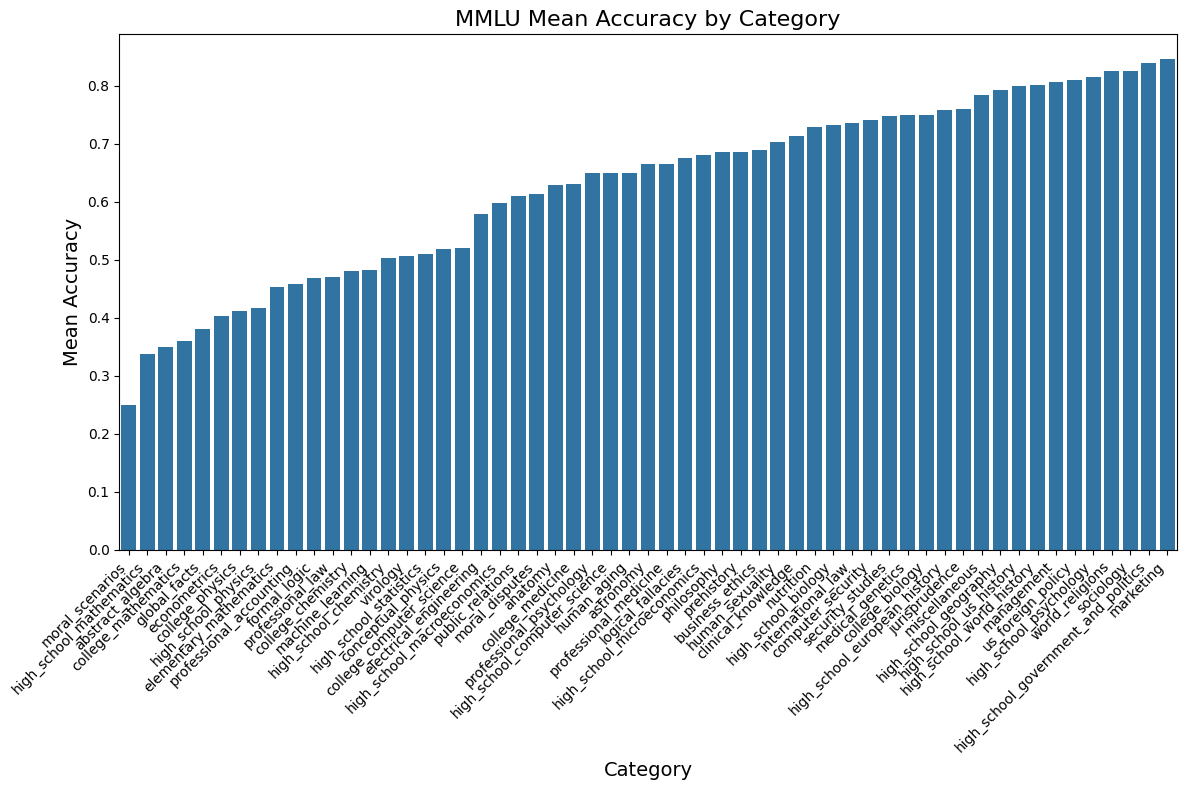

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

df = sorted_mean_accuracy_per_accuracy_df.copy(deep=True)

# Create a bar plot using seaborn
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=df, x='category', y='accuracy')

# Rotate the x labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set titles and labels
barplot.set_title('MMLU Mean Accuracy by Category', fontsize=16)
barplot.set_xlabel('Category', fontsize=14)
barplot.set_ylabel('Mean Accuracy', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


## Get average accuracy for all letter orders  

Get the average accuracy over all letter orders for the complete dataset:

In [19]:
accuracy_for_letter_order = dataset_df.copy(deep=True)
del accuracy_for_letter_order['global_answer']
accuracy_for_letter_order['is_correct'] = accuracy_for_letter_order['answer'] == accuracy_for_letter_order['inferred_answer']
accuracy_for_letter_order = accuracy_for_letter_order.groupby('letter_order')['is_correct'].mean().to_frame().reset_index().sort_values('is_correct')
accuracy_for_letter_order.columns = ['category', 'accuracy']
accuracy_for_letter_order

,category,accuracy
20,DBAC,0.497294
22,DCAB,0.503988
18,DABC,0.504202
14,CBAD,0.509329
23,DCBA,0.509899
10,BDAC,0.510113
21,DBCA,0.510326
19,DACB,0.510397
13,CADB,0.514528
15,CBDA,0.515240


/tmp/ipykernel_47/1020689081.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')


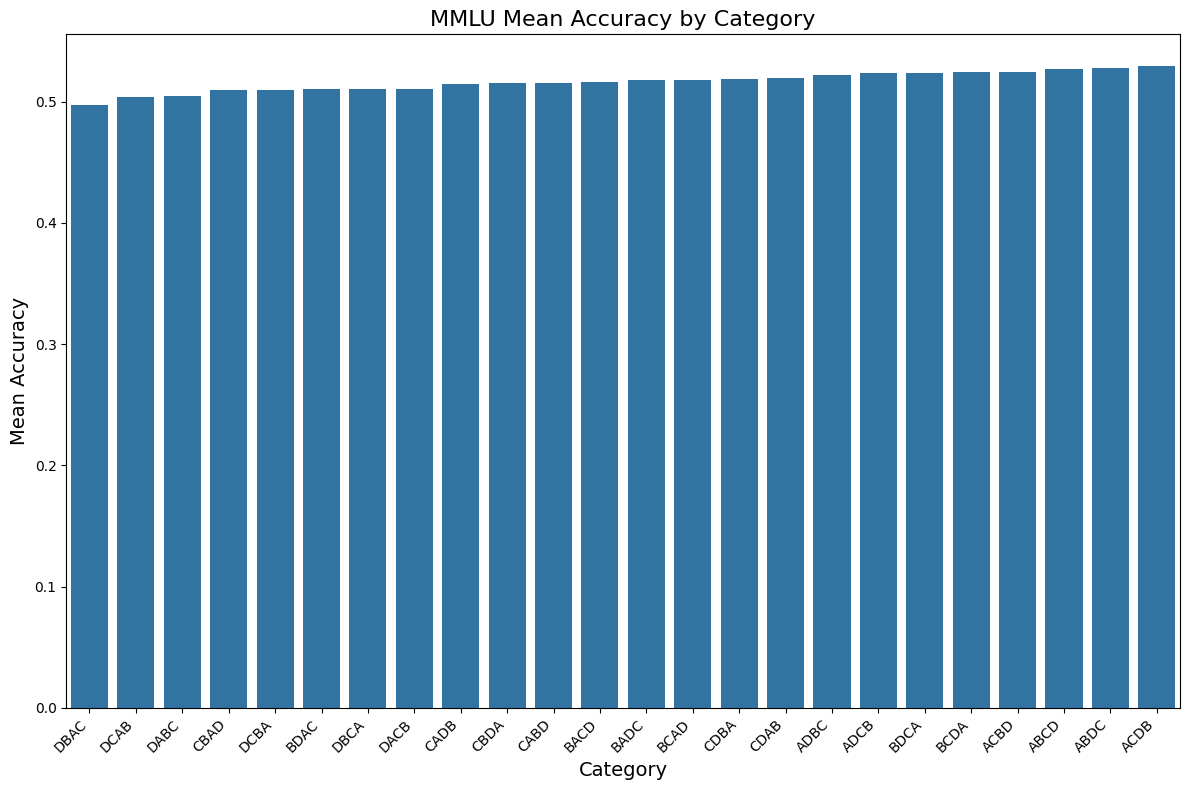

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

df = accuracy_for_letter_order.copy(deep=True)

# Create a bar plot using seaborn
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=df, x='category', y='accuracy')

# Rotate the x labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set titles and labels
barplot.set_title('MMLU Mean Accuracy by Category', fontsize=16)
barplot.set_xlabel('Category', fontsize=14)
barplot.set_ylabel('Mean Accuracy', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


Get the average accuracy for all letter orders and categories:  
(this is a very long DF)

In [21]:
accuracy_for_letter_order = dataset_df.copy(deep=True)
del accuracy_for_letter_order['global_answer']
accuracy_for_letter_order['is_correct'] = accuracy_for_letter_order['answer'] == accuracy_for_letter_order['inferred_answer']
accuracy_for_letter_order = accuracy_for_letter_order.groupby(['letter_order', 'category'])['is_correct'].mean().to_frame().reset_index().sort_values('is_correct')
accuracy_for_letter_order.columns = ['letter_order','category', 'accuracy']
accuracy_for_letter_order

,letter_order,category,accuracy
929,CDAB,global_facts,0.220000
587,BDAC,global_facts,0.220000
570,BDAC,abstract_algebra,0.230000
806,CBAD,college_mathematics,0.230000
613,BDAC,moral_scenarios,0.237989
...,...,...,...
723,CABD,marketing,0.782051
951,CDAB,marketing,0.782051
39,ABCD,marketing,0.790598
153,ACBD,marketing,0.799145


We extract the most valuable information from the previous DF by selecting best and worst results for each category:

In [22]:
import pandas as pd

# group by category and get the worst and best accuracy
worst_accuracy = accuracy_for_letter_order.loc[accuracy_for_letter_order.groupby('category')['accuracy'].idxmin()]
worst_accuracy.columns = ['worst_letter_order', 'category', 'worst_accuracy']

best_accuracy = accuracy_for_letter_order.loc[accuracy_for_letter_order.groupby('category')['accuracy'].idxmax()]
best_accuracy.columns = ['best_letter_order', 'category', 'best_accuracy']

result = pd.merge(best_accuracy, worst_accuracy, on='category')
col = result.pop("category")
result.insert(0, col.name, col)
result['delta_accuracy'] = result['best_accuracy'] - result['worst_accuracy']
result = result.sort_values('delta_accuracy', ascending=False)
result

,category,best_letter_order,best_accuracy,worst_letter_order,worst_accuracy,delta_accuracy
10,college_physics,CDAB,0.539216,ACBD,0.264706,0.274510
7,college_computer_science,CDAB,0.530000,DCBA,0.300000,0.230000
17,global_facts,CBDA,0.430000,CDAB,0.220000,0.210000
0,abstract_algebra,DCBA,0.430000,BDAC,0.230000,0.200000
16,formal_logic,BDAC,0.468254,ACBD,0.269841,0.198413
34,international_law,ACBD,0.677686,BADC,0.479339,0.198347
52,security_studies,ACDB,0.657143,DABC,0.461224,0.195918
51,public_relations,ABDC,0.627273,DCAB,0.436364,0.190909
6,college_chemistry,CDAB,0.490000,ABCD,0.300000,0.190000
19,high_school_chemistry,ABCD,0.517241,DBAC,0.334975,0.182266


We notice that some letter orders are present in both the best orders and worst orders:
(restrict on top 5 values)

In [23]:
set_of_best_letter_orders = set(result.best_letter_order.value_counts().head(5).index)
set_of_best_letter_orders

{'ACBD', 'ACDB', 'BCAD', 'BCDA', 'CDAB'}

In [24]:
set_of_worst_letter_orders = set(result.worst_letter_order.value_counts().head(5).index)
set_of_worst_letter_orders

{'ACBD', 'BDAC', 'CBAD', 'DBAC', 'DBCA'}

Best order letters NOT present in worst letter orders:

In [25]:
set_of_best_letter_orders - set_of_worst_letter_orders

{'ACDB', 'BCAD', 'BCDA', 'CDAB'}

Worst order letters NOT present in best letter orders:

In [26]:
set_of_worst_letter_orders - set_of_best_letter_orders

{'BDAC', 'CBAD', 'DBAC', 'DBCA'}

Best letter orders NOT present in worst order letters:  
(NOT restricted on top 5 most frequent order letters)

In [27]:
set(result.best_letter_order) - set(result.worst_letter_order)

{'ABDC', 'ACDB', 'ADCB', 'BCDA'}

## Count the number of agreements per letter order  

We know that the popular vote method yields a 60% good result rate.  
All letter orders accuracies are between 49-52% each.  
We wonder if certain letter orders perform better when deciding against the popular vote.  

We want to classify letter orders in 4 categories:  
1. agrees with popular vote and is right : 'beneficial follower'
2. agrees with popular vote and is wrong : 'detrimental follower'
3. disagrees with popular vote and is wrong : 'detrimental outlier'
4. disagrees with popular vote and is right : 'beneficial outlier'  

Then we can cound the repartition of these 4 categories for all letter orders and see the ones with the best influence.  

In [28]:
def label_sample(row):
    popular = row['agrees_vith_popular']    
    is_correct = row['is_correct']
    
    if popular and is_correct:
        return 'beneficial follower'
    elif popular and not is_correct:
        return 'detrimental follower'
    elif not popular and not is_correct:
        return 'detrimental outlier'
    elif not popular and is_correct:
        return 'beneficial outlier'

agreement_df = popular_df.copy(deep=True)
agreement_df['agrees_vith_popular'] = agreement_df['popular_answer'] == agreement_df['global_answer']
agreement_df['is_correct'] = agreement_df['answer'] == agreement_df['inferred_answer']

agreement_df['letter_order_type'] = agreement_df.apply(lambda row: label_sample(row), axis=1)
agreement_df.head()

,question,choices,answer,question_id,category,letter_order,inferred_answer,global_answer,popular_answer,agrees_vith_popular,is_correct,letter_order_type
0,Find the degree for the given field extension ...,"[0, 4, 2, 6]",1,bc3778ec85a3abdf375449e14780a1318d32e859c2a2c1...,abstract_algebra,ABCD,2,2,2,True,False,detrimental follower
1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...","[8, 2, 24, 120]",2,9dbee06135bb2cd4f1d6fc47c5b9698485a7758ce3ee76...,abstract_algebra,ABCD,1,1,2,False,False,detrimental outlier
2,Find all zeros in the indicated finite field o...,"[0, 1, 0,1, 0,4]",3,4cfb894cedaec3e7dee2ba71a6a781fbf1d0ded44bac22...,abstract_algebra,ABCD,2,2,3,False,False,detrimental outlier
3,Statement 1 | A factor group of a non-Abelian ...,"[True, True, False, False, True, False, False,...",1,7bdc038b56be4a1a507b6d156e061fc66c43098d756822...,abstract_algebra,ABCD,0,0,0,True,False,detrimental follower
4,Find the product of the given polynomials in t...,"[2x^2 + 5, 6x^2 + 4x + 6, 0, x^2 + 1]",1,ff99adc312cd773b4959d6f9398f00342297a0d0379c65...,abstract_algebra,ABCD,1,1,1,True,True,beneficial follower


In [29]:
agreement_df.letter_order_type.value_counts()

letter_order_type
beneficial follower     147694
detrimental outlier      91857
detrimental follower     71163
beneficial outlier       26294
Name: count, dtype: int64

In [30]:
len(agreement_df.question_id.unique())

14042

In [31]:
letter_order_label_counts_df = agreement_df.groupby(['letter_order', 'letter_order_type']).size().reset_index(name='counts')
letter_order_label_counts_df = letter_order_label_counts_df.pivot(index='letter_order', columns='letter_order_type', values='counts')
letter_order_label_counts_df['total_question_count'] = (
    letter_order_label_counts_df['beneficial follower'] +
    letter_order_label_counts_df['detrimental follower'] +
    letter_order_label_counts_df['beneficial outlier'] +
    letter_order_label_counts_df['detrimental outlier']
)

letter_order_label_counts_df['follower_accuracy'] = (
    letter_order_label_counts_df['beneficial follower'] 
    # letter_order_label_counts_df['detrimental follower']
) / letter_order_label_counts_df['total_question_count'] * 100

letter_order_label_counts_df['outlier_accuracy'] = (
    letter_order_label_counts_df['beneficial outlier'] 
    # letter_order_label_counts_df['detrimental outlier']
) / letter_order_label_counts_df['total_question_count'] * 100

letter_order_label_counts_df['total_accuracy'] = (
    letter_order_label_counts_df['follower_accuracy'] +
    letter_order_label_counts_df['outlier_accuracy']
)

letter_order_label_counts_df

letter_order_type,beneficial follower,beneficial outlier,detrimental follower,detrimental outlier,total_question_count,follower_accuracy,outlier_accuracy,total_accuracy
letter_order,,,,,,,,
ABCD,6390,1010,3161,3481,14042,45.506338,7.192708,52.699046
ABDC,6416,991,3371,3264,14042,45.691497,7.057399,52.748896
ACBD,6367,998,3306,3371,14042,45.342544,7.107250,52.449793
ACDB,6236,1192,2637,3977,14042,44.409628,8.488819,52.898448
ADBC,6330,993,3374,3345,14042,45.079049,7.071642,52.150691
ADCB,6179,1171,2747,3945,14042,44.003703,8.339268,52.342971
BACD,6117,1127,2742,4056,14042,43.562171,8.025922,51.588093
BADC,6057,1214,2631,4140,14042,43.134881,8.645492,51.780373
BCAD,6095,1180,2709,4058,14042,43.405498,8.403361,51.808859


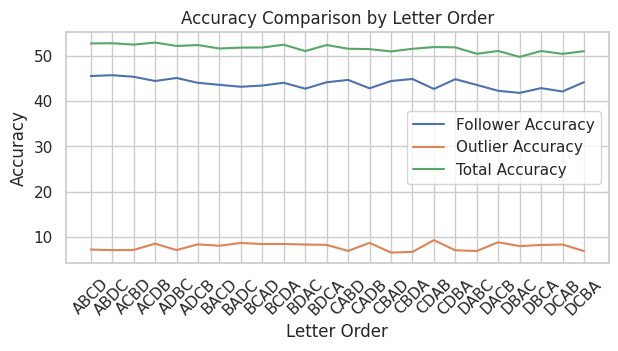

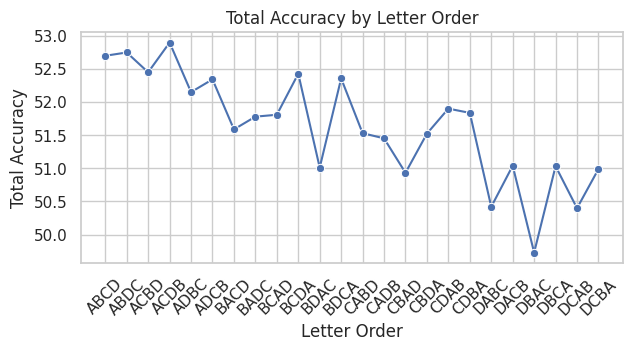

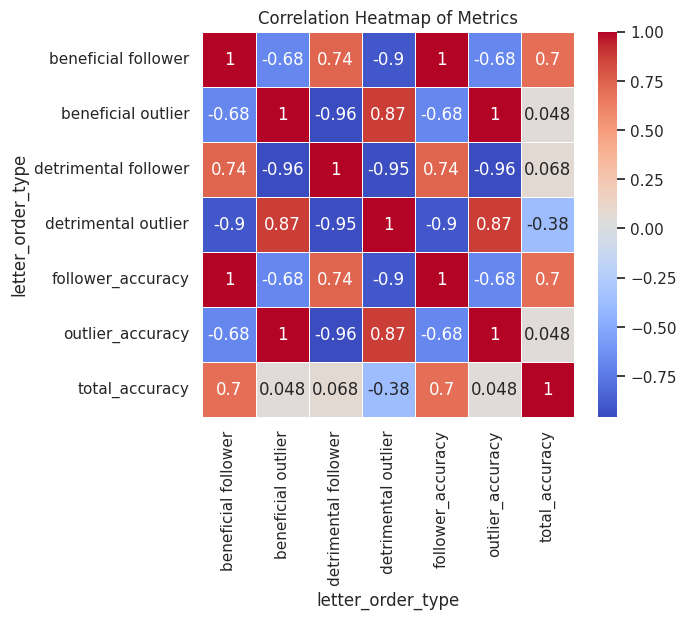

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Plot 1: Accuracy Comparison
plt.figure(figsize=(7, 3))
sns.lineplot(x='letter_order', y='follower_accuracy', data=letter_order_label_counts_df, label='Follower Accuracy')
sns.lineplot(x='letter_order', y='outlier_accuracy', data=letter_order_label_counts_df, label='Outlier Accuracy')
sns.lineplot(x='letter_order', y='total_accuracy', data=letter_order_label_counts_df, label='Total Accuracy')
plt.xlabel('Letter Order')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison by Letter Order')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot 2: Total Accuracy vs. Letter Order
plt.figure(figsize=(7, 3))
sns.lineplot(x=letter_order_label_counts_df.index, y='total_accuracy', data=letter_order_label_counts_df, marker='o')
plt.xlabel('Letter Order')
plt.ylabel('Total Accuracy')
plt.title('Total Accuracy by Letter Order')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Correlation Heatmap
plt.figure(figsize=(6, 5))
correlation_matrix = letter_order_label_counts_df[['beneficial follower', 'beneficial outlier', 'detrimental follower', 'detrimental outlier', 'follower_accuracy', 'outlier_accuracy', 'total_accuracy']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Metrics')
plt.show()


In [33]:
letter_order_label_counts_df.to_csv('export.csv')

We observe poor outlier performance across all letter orders.  
We do not see a relationship between follower or outlier performance: some letter orders are great in both categories while others perform badly in both categories. Being a beneficial outlier doesn't seem to be correlated with being a beneficial follower.  

## Count the number of letter orders needed to achieve a given score  
It took a long time to compute all 24 letter order over MMLU.  
By selecting N letter orders and computing the result of the vote, we can see where we hit diminishing returns.  

### Find a way to select representative letter orders to add to our experiment  

As we will be selecting a subset of the 24 letter order permutations, we need to find a method to select N letter orders in a way that is not influenced by their respective accuracy (so the MMLU doesn't influence ground truth, we want a generalisation).  
We also want the selected letter orders to not be either too well performing or underperforming, and get a uniform letter position representation.  

Our upper test limit will be 10 letter orders, which could offer a 2x speedup over the complete 24 letter orders.  

#### Select all letter orders that have a letter in a different position than ABCD  

This method yields 9 choices, if we add our initial ABCD letter order, we can get 10 total orders.  
We can then iteratively add these orders until we hit 10, our upper limit.  

We make a list of all letter orders which do not have a letter at the original position:

In [34]:
all_letter_orders = list(agreement_df.letter_order.unique())

original_letter_order = 'ABCD'  

most_original_letter_orders = []
for letter_order in all_letter_orders:
    if letter_order[0] == 'A':
        continue
    elif letter_order[1] == 'B':
        continue
    elif letter_order[2] == 'C':
        continue
    elif letter_order[3] == 'D':
        continue
    else:
        most_original_letter_orders.append(letter_order)

selected_10_letter_orders = most_original_letter_orders + [original_letter_order]
selected_10_letter_orders

['BADC',
 'BCDA',
 'BDAC',
 'CADB',
 'CDAB',
 'CDBA',
 'DABC',
 'DCAB',
 'DCBA',
 'ABCD']

In [35]:
def show_accuracy_for_two_groups(selected_10_letter_orders):
    selected_10_acc = letter_order_label_counts_df[letter_order_label_counts_df.index.isin(selected_10_letter_orders)].total_accuracy.mean()
    not_selected_acc = letter_order_label_counts_df[~letter_order_label_counts_df.index.isin(selected_10_letter_orders)].total_accuracy.mean()
    
    print(f" A : Accuracy of selected group : {selected_10_acc}")
    print(f" B : Accuracy of not-selected group : {not_selected_acc}")
    print(f"Difference between the two groups (A - B) : {selected_10_acc - not_selected_acc}")

In [36]:
def average_position(strings):
    letter_count = {}
    total_positions = {}
    
    # Count occurrences and calculate total positions for each letter
    for string in strings:
        for i, letter in enumerate(string):
            if letter not in letter_count:
                letter_count[letter] = 0
                total_positions[letter] = 0
            letter_count[letter] += 1
            total_positions[letter] += i + 1
    
    # Calculate average position for each letter
    averages = {}
    for letter, count in letter_count.items():
        averages[letter] = total_positions[letter] / count

    # Sort the dictionary by keys alphabetically
    return {k: averages[k] for k in sorted(averages)}

In [37]:
show_accuracy_for_two_groups(selected_10_letter_orders)

 A : Accuracy of selected group : 51.4919527132887
 B : Accuracy of not-selected group : 51.72390990294422
Difference between the two groups (A - B) : -0.2319571896555246


In [38]:
average_position(selected_10_letter_orders)

{'A': 2.8, 'B': 2.6, 'C': 2.4, 'D': 2.2}

#### Hamming distance  

We select 10 permutations that have the largest Hamming distance between them.  
This is similar to the previous method,but generalized.  
Instead of comparing all letter orders against the initial ABCD, we compare each sample against all other samples and ensure a diversity in letter positions.  

In [39]:
import itertools
import numpy as np

# Step 1: Generate all permutations
permutations = list(map("".join, itertools.permutations("ABCD")))

# Step 2: Calculate Hamming distances
def hamming_distance(s1, s2):
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

n = len(permutations)
distances = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in range(i+1, n):
        dist = hamming_distance(permutations[i], permutations[j])
        distances[i, j] = dist
        distances[j, i] = dist

# Step 3: Select initial permutation
selected = [0]  # Start with the first permutation (index 0)

# Step 4: Iteratively select the most diverse permutations
for _ in range(9):  # We need 10 permutations in total
    last_selected = selected[-1]
    max_min_dist = -1
    next_selected = None
    for i in range(n):
        if i in selected:
            continue
        min_dist = min(distances[i, j] for j in selected)
        if min_dist > max_min_dist:
            max_min_dist = min_dist
            next_selected = i
    selected.append(next_selected)

# Print the selected permutations
selected_permutations_h = [permutations[i] for i in selected]
selected_permutations_h

['ABCD',
 'BADC',
 'CDAB',
 'DCBA',
 'ACDB',
 'ADBC',
 'BCAD',
 'BDCA',
 'CABD',
 'CBDA']

In [40]:
show_accuracy_for_two_groups(selected_permutations_h)

 A : Accuracy of selected group : 51.96410767696909
 B : Accuracy of not-selected group : 51.38665635745824
Difference between the two groups (A - B) : 0.5774513195108497


In [41]:
average_position(selected_permutations_h)

{'A': 2.5, 'B': 2.4, 'C': 2.3, 'D': 2.8}

#### Levenshtein distance  

The difference with the Hamming distance, given that all letter orders are 4 chars, is that we now account for groups of letters having the same position.  

In [42]:
import itertools
from Levenshtein import distance as levenshtein_distance
import numpy as np

# Generate all permutations
permutations = list(map("".join, itertools.permutations("ABCD")))

# Calculate Levenshtein distances
n = len(permutations)
distances = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in range(i + 1, n):
        dist = levenshtein_distance(permutations[i], permutations[j])
        distances[i, j] = dist
        distances[j, i] = dist

# Select initial permutation
selected = [0]  # Start with the first permutation (index 0)

# Iteratively select the most diverse permutations
for _ in range(9):  # We need 10 permutations in total
    max_min_dist = -1
    next_selected = None
    for i in range(n):
        if i in selected:
            continue
        min_dist = min(distances[i, j] for j in selected)
        if min_dist > max_min_dist:
            max_min_dist = min_dist
            next_selected = i
    selected.append(next_selected)

# Print the selected permutations
selected_permutations_l = [permutations[i] for i in selected]
selected_permutations_l

['ABCD',
 'BDAC',
 'CADB',
 'DCBA',
 'ABDC',
 'ACBD',
 'ACDB',
 'ADBC',
 'ADCB',
 'BACD']

In [43]:
show_accuracy_for_two_groups(selected_permutations_l)

 A : Accuracy of selected group : 52.03318615581826
 B : Accuracy of not-selected group : 51.33731458685169
Difference between the two groups (A - B) : 0.6958715689665667


In [44]:
average_position(selected_permutations_l)

{'A': 1.7, 'B': 2.7, 'C': 2.8, 'D': 2.8}

#### Conclusion : Hamming distance is the fairest way to proceed  

##### Method 1 (original letter order plus all orders that have letters in a different position)  
This yields the closest accuracy difference between both groups (selected and non-selected by order letters we chose).  
However, the letter 'A' is never at the beginning, and D is never at the end (as specified, except for ABCD original order), which is a huge bias.  
If we were to select random samples, this would rarely happen.  

##### Method 2 : Hamming distance  
This is the best method as the accuracy difference between two groups is not too high, and not too low (between methods 1 & 2).  
It also has the best letter repartition, with a fair amount of letter orders starting by 'A' and ending by 'D'.  
We choose this selection method.  

##### Method 3 : Levenshtein distance  
This is the worst method, as the output letter orders are heavily biased towards letter 'A'.  
Moreover, there is a large accuracy gap between select and not-selected groups.  


### Iteratively add letter orders from the Hamming selection and measure voting accuracy

Make a function to get the mean accuracy for complete MMLU using a letter order selection:

In [45]:
def get_total_mean_accuracy_for_letter_order_selection(letter_order_selection):
    iterative_popular_df = popular_df.copy(deep=True)
    del iterative_popular_df['popular_answer']
    iterative_popular_df = iterative_popular_df[iterative_popular_df.letter_order.isin(letter_order_selection)]
    
    most_frequent_term = iterative_popular_df.groupby('question_id')['global_answer'].apply(lambda x: x.value_counts().idxmax())
    
    popular_answer_df = most_frequent_term.to_frame()
    popular_answer_df.reset_index(inplace=True)
    popular_answer_df.columns = ['question_id', 'popular_answer']
    
    iterative_popular_df = pd.merge(left=iterative_popular_df, right=popular_answer_df, on='question_id', how='left')
    
    iterative_popular_df = iterative_popular_df[iterative_popular_df.letter_order == 'ABCD']
    iterative_popular_df['is_correct'] = iterative_popular_df['answer'] == iterative_popular_df['popular_answer']
    
    return iterative_popular_df['is_correct'].mean()

letter_order_selection = ['ABCD']
get_total_mean_accuracy_for_letter_order_selection(letter_order_selection)

0.5269904571998291

We take the Hamming letter_order selection and incrementally add order letters to get a list of accuracies.  
We will also shuffle the selected letter orders 10 times to minimize the influence of letter_order introduction order.  
We will always start with ABCD then add letter orders, so we can still compare the starting point with other benchmarks.  

In [46]:
selected_permutations_h.pop(0) #remove 'ABCD'
selected_permutations_h

['BADC', 'CDAB', 'DCBA', 'ACDB', 'ADBC', 'BCAD', 'BDCA', 'CABD', 'CBDA']

In [47]:
from tqdm.auto import tqdm
import random

result_list = []
for shuffle_count in tqdm(range(10), 'shuffles'):
    random.shuffle(selected_permutations_h)
    for i in tqdm(range(10), desc='performing votes'):
        selected_letter_orders = selected_permutations_h[0:i]
        selected_letter_orders = ['ABCD'] + selected_letter_orders
        result_list.append({
            'shuffle_id': shuffle_count,
            'letter_order_count':i+1,
            'selected_letter_orders':'-'.join(selected_letter_orders),
            'avg_accuracy': get_total_mean_accuracy_for_letter_order_selection(selected_letter_orders),
        })

shuffles:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
result_df = pd.DataFrame(result_list)

We check that the first accuracy is always the same:  

In [49]:
result_df[result_df.selected_letter_orders == 'ABCD']

,shuffle_id,letter_order_count,selected_letter_orders,avg_accuracy
0,0,1,ABCD,0.52699
10,1,1,ABCD,0.52699
20,2,1,ABCD,0.52699
30,3,1,ABCD,0.52699
40,4,1,ABCD,0.52699
50,5,1,ABCD,0.52699
60,6,1,ABCD,0.52699
70,7,1,ABCD,0.52699
80,8,1,ABCD,0.52699
90,9,1,ABCD,0.52699


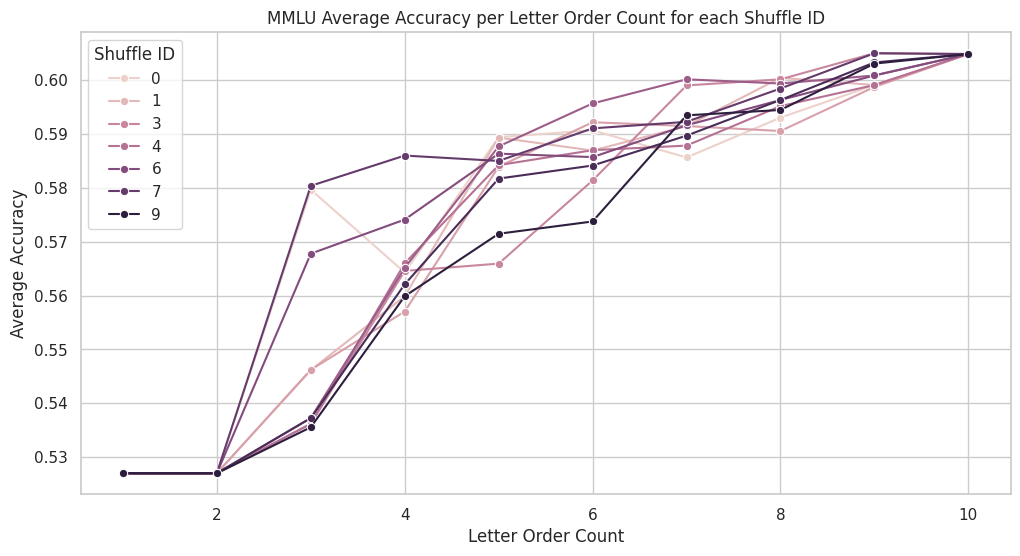

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the lineplot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=result_df, x='letter_order_count', y='avg_accuracy', hue='shuffle_id', marker='o')

# Set plot labels and title
plt.xlabel('Letter Order Count')
plt.ylabel('Average Accuracy')
plt.title('MMLU Average Accuracy per Letter Order Count for each Shuffle ID')
plt.legend(title='Shuffle ID')

# Show the plot
plt.show()

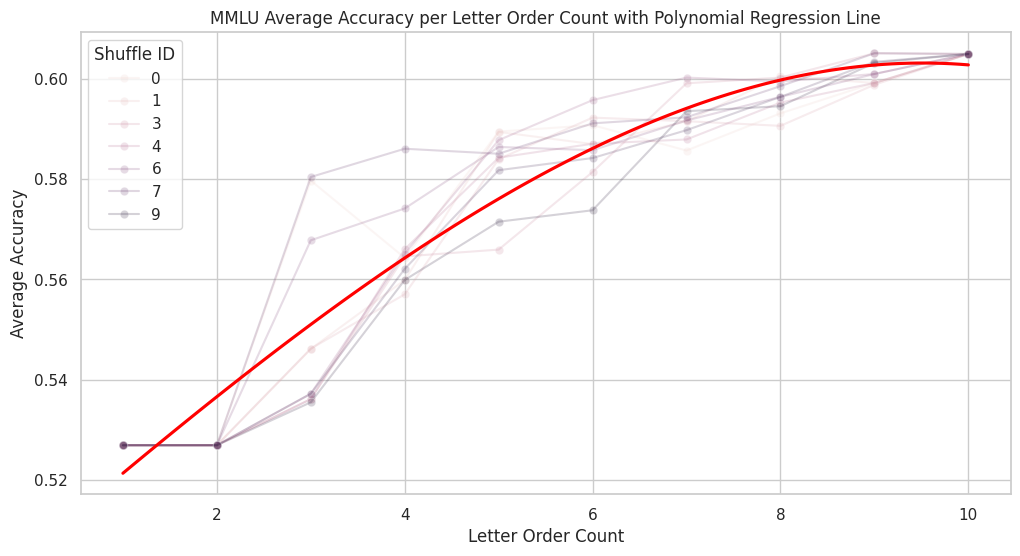

In [51]:
# Re-create the plot with points and a polynomial regression line
plt.figure(figsize=(12, 6))
sns.lineplot(data=result_df, x='letter_order_count', y='avg_accuracy', hue='shuffle_id', estimator=None, alpha=0.2, marker='o')
sns.regplot(data=result_df, x='letter_order_count', y='avg_accuracy', scatter=False, order=3, ci=None, color='red')

# Set plot labels and title
plt.xlabel('Letter Order Count')
plt.ylabel('Average Accuracy')
plt.title('MMLU Average Accuracy per Letter Order Count with Polynomial Regression Line')
plt.legend(title='Shuffle ID')

plt.show()

### Small random sample of all letter orders  

When using Hamming distance, we have a representative sample of all letter orders from an input perspective.  
However, from dataset to dataset, there are still biases.  
In the previous example, we can see a great amount of variation from run to run, with constant progress, or regressions, depending on the order of letter order addition to the voting members.  

To compromise between comprehensive analysis and computing time, we will analyze 100 random letter order suites over all 24 possible letter orders.  

In [60]:
from tqdm.auto import tqdm
import random

selected_permutations_a = list(map("".join, itertools.permutations("ABCD")))
selected_permutations_a.pop(0)

result_list_r = []
for shuffle_count in tqdm(range(10), 'shuffles'):
    random.shuffle(selected_permutations_a)
    for i in tqdm(range(24), desc='performing votes'):
        selected_letter_orders = selected_permutations_a[0:i]
        selected_letter_orders = ['ABCD'] + selected_letter_orders
        result_list_r.append({
            'shuffle_id': shuffle_count,
            'letter_order_count':i+1,
            'selected_letter_orders':'-'.join(selected_letter_orders),
            'avg_accuracy': get_total_mean_accuracy_for_letter_order_selection(selected_letter_orders),
        })

result_df_r = pd.DataFrame(result_list_r)

shuffles:   0%|          | 0/10 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

performing votes:   0%|          | 0/24 [00:00<?, ?it/s]

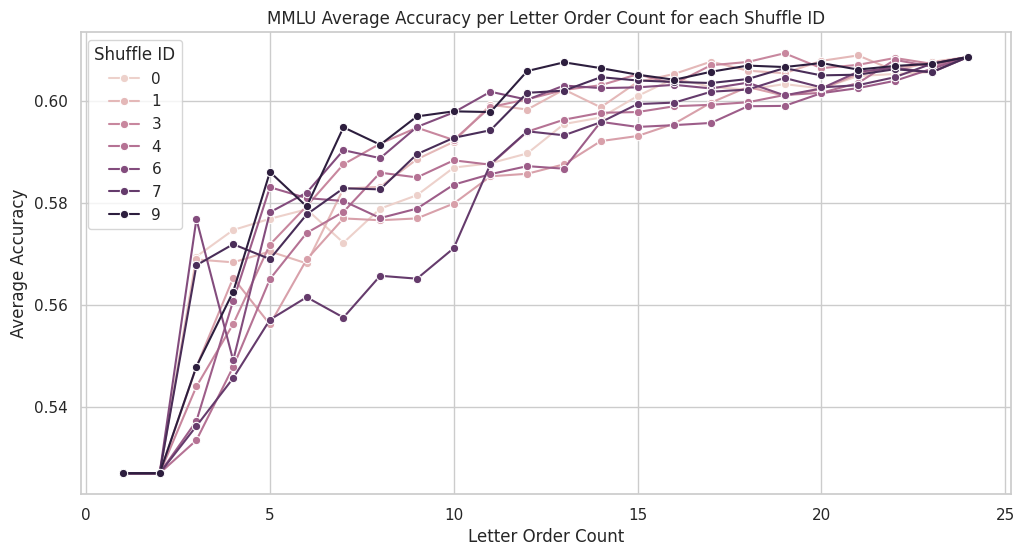

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the lineplot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=result_df_r, x='letter_order_count', y='avg_accuracy', hue='shuffle_id', marker='o')

# Set plot labels and title
plt.xlabel('Letter Order Count')
plt.ylabel('Average Accuracy')
plt.title('MMLU Average Accuracy per Letter Order Count for each Shuffle ID')
plt.legend(title='Shuffle ID')

# Show the plot
plt.show()

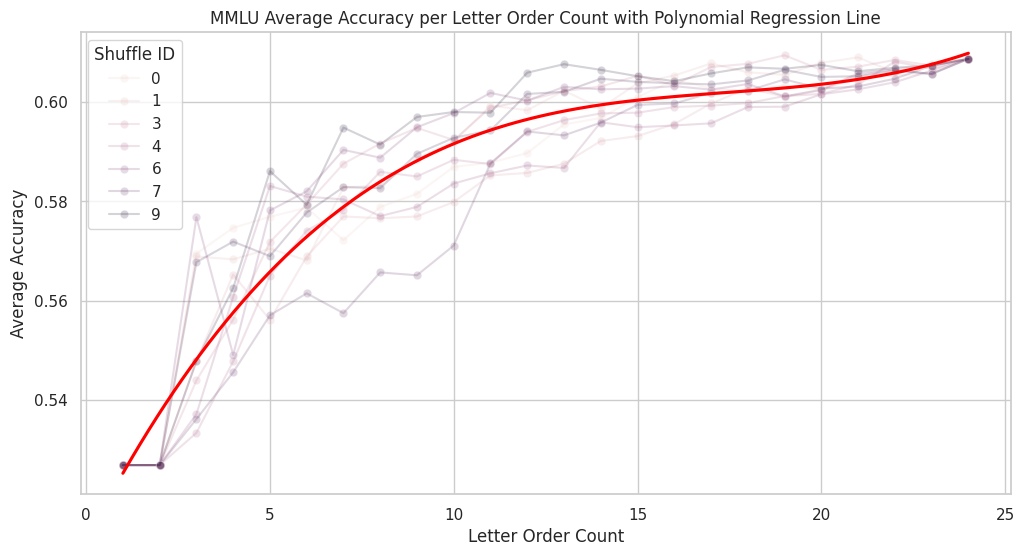

In [63]:
# Re-create the plot with points and a polynomial regression line
plt.figure(figsize=(12, 6))
sns.lineplot(data=result_df_r, x='letter_order_count', y='avg_accuracy', hue='shuffle_id', estimator=None, alpha=0.2, marker='o')
sns.regplot(data=result_df_r, x='letter_order_count', y='avg_accuracy', scatter=False, order=3, ci=None, color='red')

# Set plot labels and title
plt.xlabel('Letter Order Count')
plt.ylabel('Average Accuracy')
plt.title('MMLU Average Accuracy per Letter Order Count with Polynomial Regression Line')
plt.legend(title='Shuffle ID')

plt.show()

## Analyze the influence of letter position in a letter order  

A letter order is a permutation of letters ABCD.  
We observed (at a glance) that letter orders where letter "A" were placed at position 0 seemed to perform better.  

We wonder if the position of a letter in a letter order is correlated to better or poorer mean accuracy over complete MMLU.  

To find out, we encode letter position over 4 new features (`pos_A` to `pos_D`).  
Then compute mean position and mean average, and display relevant plots.  

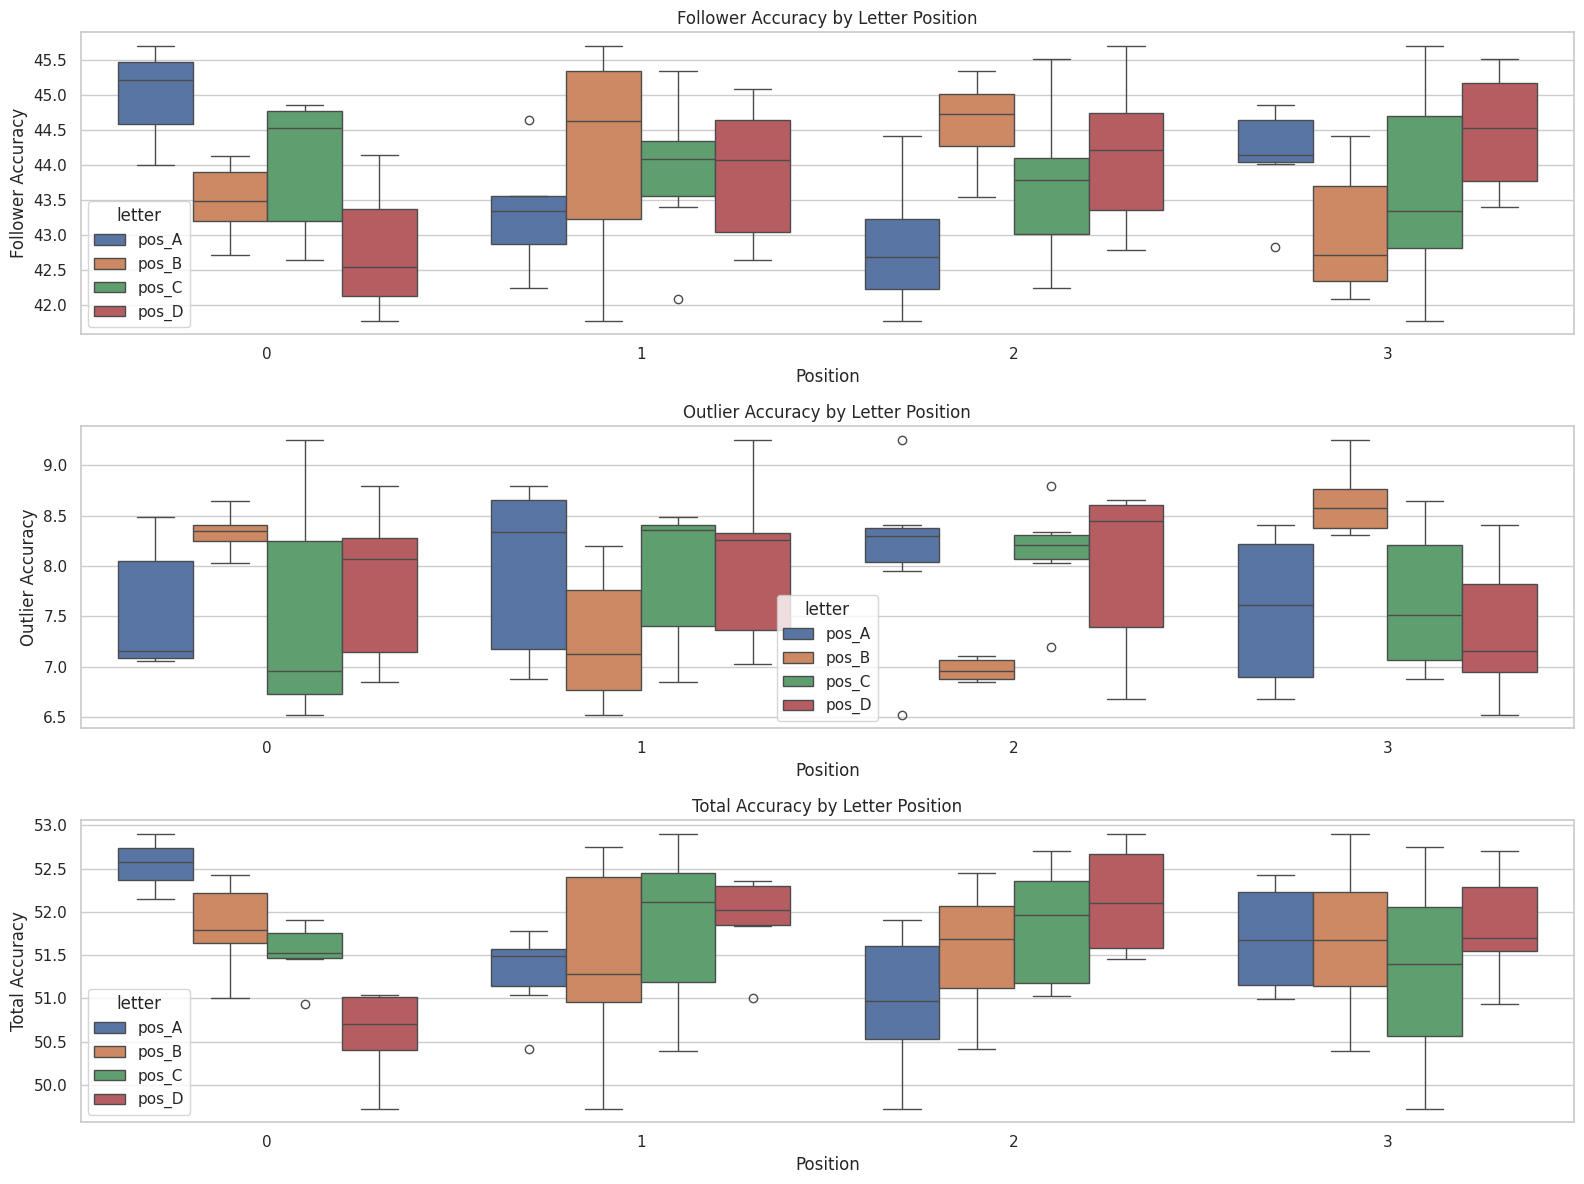

In [64]:
df = letter_order_label_counts_df.copy(deep=True)
df.reset_index(inplace=True)

# Create new columns indicating the position of each letter (A, B, C, D) in the letter_order
df['pos_A'] = df['letter_order'].apply(lambda x: x.index('A'))
df['pos_B'] = df['letter_order'].apply(lambda x: x.index('B'))
df['pos_C'] = df['letter_order'].apply(lambda x: x.index('C'))
df['pos_D'] = df['letter_order'].apply(lambda x: x.index('D'))

# Melt the dataframe to facilitate plotting
df_melted_positions = df.melt(id_vars=['letter_order', 'follower_accuracy', 'outlier_accuracy', 'total_accuracy'], 
                              value_vars=['pos_A', 'pos_B', 'pos_C', 'pos_D'], 
                              var_name='letter', value_name='position')

# Create a dataframe to calculate mean accuracies based on letter positions
del df_melted_positions['letter_order']
mean_accuracies = df_melted_positions.groupby(['letter', 'position']).mean().reset_index()

# Plot 1: Box Plots of Accuracies for Each Letter Position
plt.figure(figsize=(16, 12))
for i, accuracy_type in enumerate(['follower_accuracy', 'outlier_accuracy', 'total_accuracy']):
    plt.subplot(3, 1, i+1)
    sns.boxplot(x='position', y=accuracy_type, hue='letter', data=df_melted_positions)
    plt.title(f'{accuracy_type.replace("_", " ").title()} by Letter Position')
    plt.xlabel('Position')
    plt.ylabel(accuracy_type.replace('_', ' ').title())

plt.tight_layout()
plt.show()

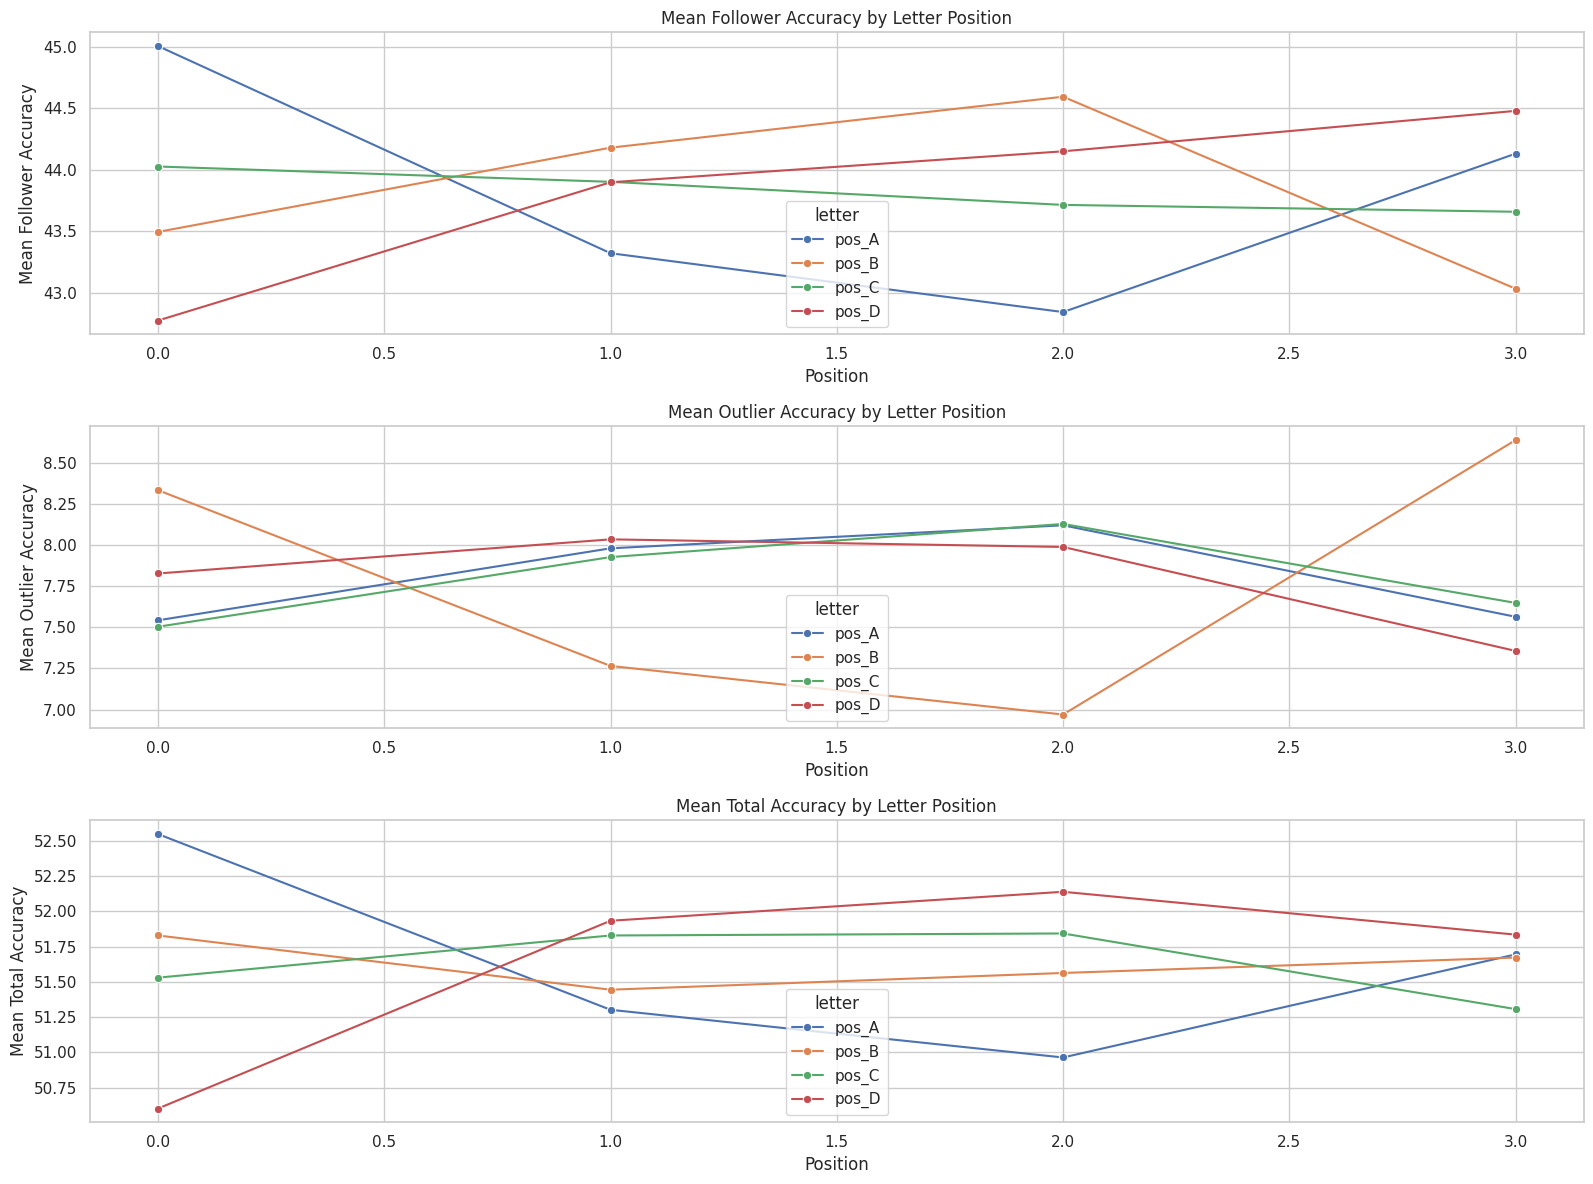

In [65]:
# Plot 2: Line Plots of Mean Accuracies for Each Letter Position
plt.figure(figsize=(16, 12))
for i, accuracy_type in enumerate(['follower_accuracy', 'outlier_accuracy', 'total_accuracy']):
    plt.subplot(3, 1, i+1)
    sns.lineplot(x='position', y=accuracy_type, hue='letter', data=mean_accuracies, marker='o')
    plt.title(f'Mean {accuracy_type.replace("_", " ").title()} by Letter Position')
    plt.xlabel('Position')
    plt.ylabel(f'Mean {accuracy_type.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

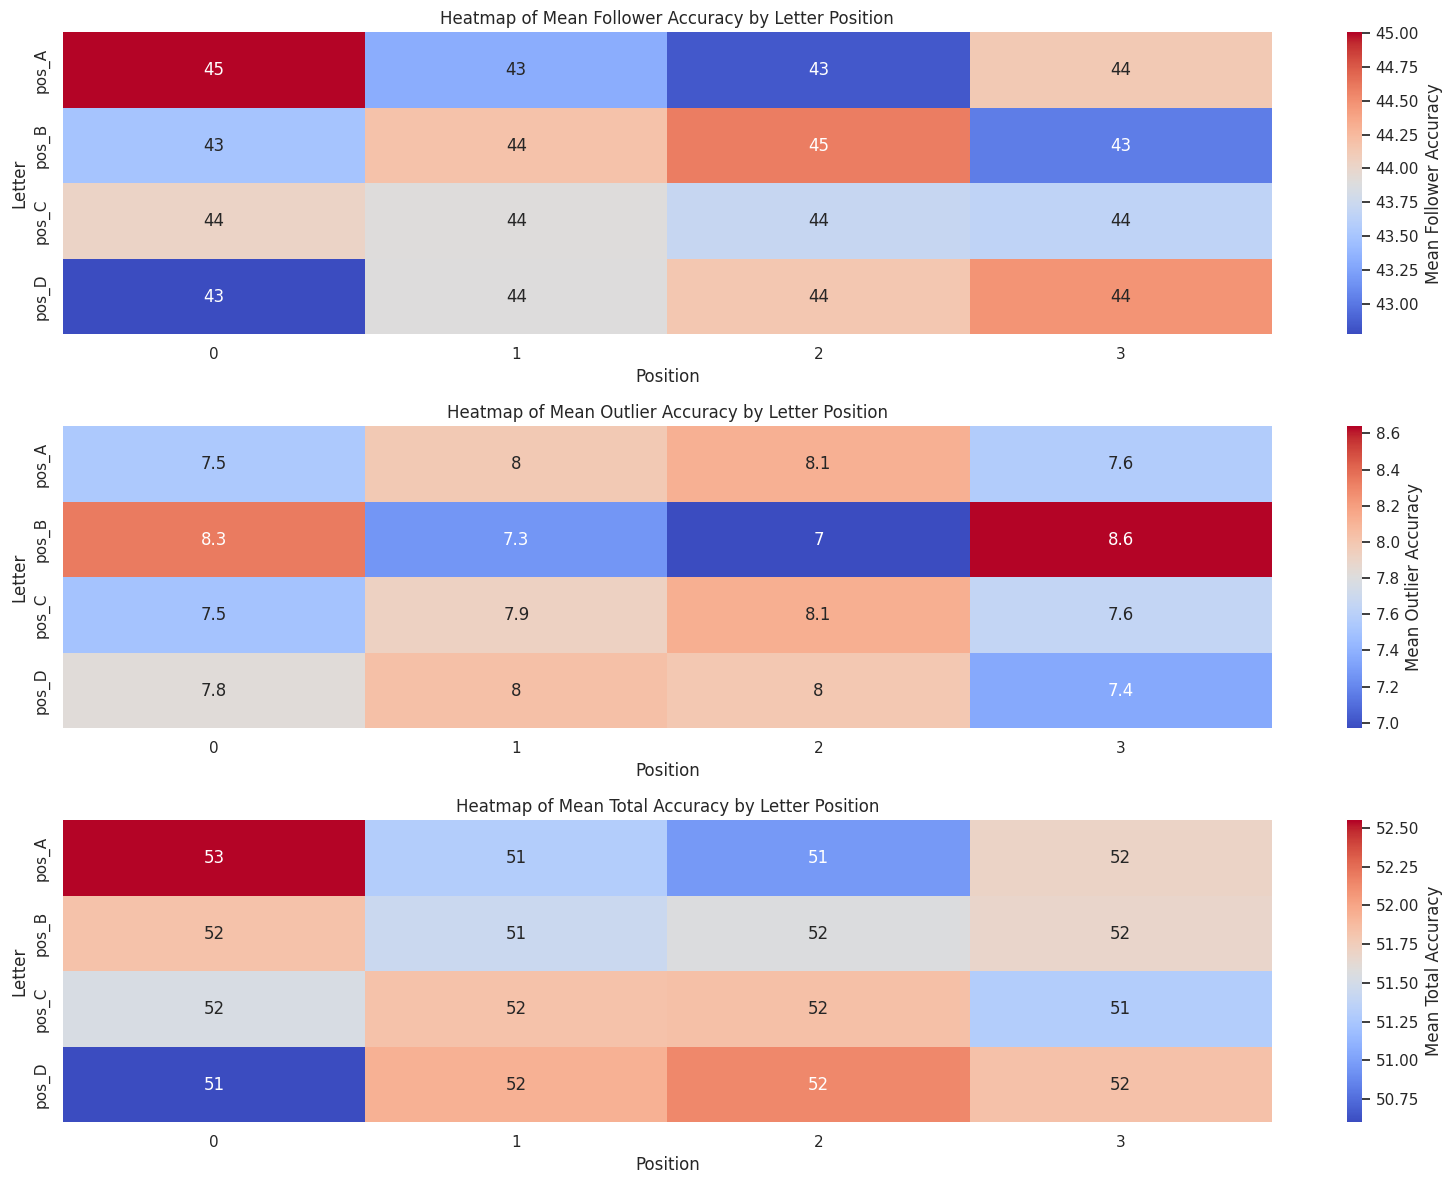

In [66]:
# Plot 3: Heatmaps of Mean Accuracies for Each Letter Position (corrected)
plt.figure(figsize=(16, 12))
for i, accuracy_type in enumerate(['follower_accuracy', 'outlier_accuracy', 'total_accuracy']):
    plt.subplot(3, 1, i+1)
    heatmap_data = mean_accuracies.pivot(index='letter', columns='position', values=accuracy_type)
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': f'Mean {accuracy_type.replace("_", " ").title()}'})
    plt.title(f'Heatmap of Mean {accuracy_type.replace("_", " ").title()} by Letter Position')
    plt.xlabel('Position')
    plt.ylabel('Letter')

plt.tight_layout()
plt.show()

Our findings support the slightly better mean accuracy for letter A at the beginning, and also show a slightly better accuracy for letter D at position number 3 (index 2).  


## Conclusion  

We have translated the question answer from a local answer to a global answer, and computed the most popular answer.  
We have computed the accuracy by vote, category, letter order.  
We have analyzed the decomposition of voters over 4 categories (beneficial/detrimental follower/outlier).  
We have analyzed the influence of vote count over accuracy.  
We have analyzed the influence of letter position over accuracy.  

We observe that:  
- using all 24 letter orders increases average accuracy from 50% to 60% (+10 perc. points)
- using 10 letter orders is the sweet spot before decreasing returns between added accuracy and computing cost  
- no letter order operates best outside of the voting strategy (there are no beneficial outliers)  
- some letter orders are beneficial to some categories while being detrimental to other categories: no letter order is absolutely ideal for the complete dataset  
- the letter position in a letter order has no meaningful influence over total mean accuracy

Our 2 main takeways:  
- Given that no letter order is best, the special ingredient is collective intelligence: the voting principle is making the complete system perform better
- 10 shuffles of a given question are enough to achieve approx +10 percentage points of accuracy while needing 2x less computations that the complete set of 24 permutations.  